# MobileNet + tensorboard + torchinfo + Epoch당 걸리는 시간

## MobileNet 개념 정리
https://coding-yoon.tistory.com/122
## MobileNet 실습 코드
https://deep-learning-study.tistory.com/549

In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as tr
from torch.utils.data import Dataset, DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

# FER Summary
from skimage import io, transform
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import re
import PIL

# random seed fixed
''' random seed fixed'''
import random
import torch.backends.cudnn as cudnn

path = "/home/sldev1/Project/hyeongeun_test/data/FER"
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [2]:
from torch.utils.data import Dataset
import glob


def img_load(img_path):

    jpg = glob.glob(img_path+'*.jpg')
    sort_jpg = sorted(jpg, key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("img_load def is play")
    return sort_jpg


def label_load(label_path):
    #enumerate #파이썬내장함수.. 강민규사원님은 이걸로 쓰셨는데 느리더래
    label = glob.glob(label_path+'*exp.npy')
    sort_label = sorted(label,key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("label_load def is play")
    return sort_label
    
    
    
class MyFERDataset(Dataset):
    
    def __init__(self, img_path_base, label_path_base, train=None, transform=None):
        super(MyFERDataset, self).__init__()
        
        if train == True:
            self.img_path = img_path_base+'/train_set/images/'
            self.label_path = label_path_base+'/train_set/annotations/'
        else:
            self.img_path = img_path_base+'/val_set/images/'
            self.label_path = label_path_base+'/val_set/annotations/'

        self.img = img_load(self.img_path)
        self.label = label_load(self.label_path)
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_read = io.imread(self.img[idx]) 
        label_read = np.load(self.label[idx])
        label_read = label_read.astype(np.int64)
        label_tr = torch.from_numpy(label_read)
        
        
        if self.transform:
            img_tr = self.transform(img_read)
        
        
        return img_tr, label_tr
    

    def __len__(self):
        return len(self.label)
    
    if __name__ == "__main__":
        print('hi, i\'m main')

hi, i'm main


In [3]:
transform_train = tr.Compose([tr.ToTensor(),
                              tr.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_test = tr.Compose([tr.ToTensor()])


train_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=True,
                              transform=transform_train)
test_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=False,
                              transform=transform_test)

In [4]:
len(train_dataset)

287651

In [5]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
dataiter = iter(train_dl)
images, labels = dataiter.next()

In [7]:
labels.size()
#print(images)

torch.Size([32])

In [8]:
print(labels)

tensor([0, 1, 0, 1, 1, 1, 0, 3, 0, 0, 6, 0, 1, 1, 1, 1, 0, 1, 0, 2, 3, 6, 1, 1,
        0, 0, 2, 1, 5, 1, 1, 6])


In [9]:
# Depthwise Separable Convolution
class Depthwise(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=stride, padding=1, groups=in_channels, bias=False),
            # ==> kernel size = 3 이란 말은, 3x3을 의미함.
            # ==> nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [10]:
# Basic Conv2d
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

alpha : [링크](https://keras.io/api/applications/mobilenet/)   
네트워크의 너비를 제어합니다. 이것은 MobileNet 문서에서 너비 승수로 알려져 있습니다. - alpha< 1.0이면 각 레이어의 필터 수를 비례적으로 줄입니다. - alpha> 1.0인 경우 각 레이어의 필터 수를 비례적으로 늘립니다. - alpha= 1인 경우 용지의 기본 필터 수가 각 레이어에서 사용됩니다. 기본값은 1.0입니다.


In [11]:
# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self, width_multiplier, num_classes=10, init_weights=True):
        super().__init__()
        self.init_weights=init_weights
        alpha = width_multiplier

        self.conv1 = BasicConv2d(3, int(32*alpha), 3, stride=2, padding=1)
        self.conv2 = Depthwise(int(32*alpha), int(64*alpha), stride=1)
        # down sample
        self.conv3 = nn.Sequential(
            Depthwise(int(64*alpha), int(128*alpha), stride=2),
            Depthwise(int(128*alpha), int(128*alpha), stride=1)
        )
        # down sample
        self.conv4 = nn.Sequential(
            Depthwise(int(128*alpha), int(256*alpha), stride=2),
            Depthwise(int(256*alpha), int(256*alpha), stride=1)
        )
        # down sample
        self.conv5 = nn.Sequential(
            Depthwise(int(256*alpha), int(512*alpha), stride=2),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
            Depthwise(int(512*alpha), int(512*alpha), stride=1),
        )
        # down sample
        self.conv6 = nn.Sequential(
            Depthwise(int(512*alpha), int(1024*alpha), stride=2)
        )
        # down sample
        self.conv7 = nn.Sequential(
            Depthwise(int(1024*alpha), int(1024*alpha), stride=2)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(int(1024*alpha), num_classes)

        # weights initialization
        if self.init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    # weights initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def mobilenet(alpha=1, num_classes=10):
    return MobileNet(alpha, num_classes)

In [12]:
device = 'cuda'
model = mobilenet(alpha=1, num_classes=8).to(device)
x = torch.randn((3, 3, 224, 224)).to(device)
output = model(x)
print('output size:', output.size())

output size: torch.Size([3, 8])


In [13]:
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
       BasicConv2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]           2,048
       BatchNorm2d-9         [-1, 64, 112, 112]             128
            ReLU6-10         [-1, 64, 112, 112]               0
        Depthwise-11         [-1, 64, 112, 112]               0
           Conv2d-12           [-1, 64, 56, 56]             576
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            ReLU6-14           [-1, 64,

In [14]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    
    writer = SummaryWriter()
    
    
    for epoch in range(num_epochs):
        
        if epoch == 0:
            start = time.time()
        if epoch == 1:
            epoch_time_for_1 = time.time()-start
            timer = epoch_time_for_1 * num_epochs
            print("학습에 총 걸리는 시간 :", timer/3600, "시간")
        
        
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
    
        
        # writer
        writer.add_scalar('acc/train', train_metric*100, epoch)
        writer.add_scalar('loss/train', train_loss, epoch) 
        
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        # writer
        writer.add_scalar('acc/valid', val_metric*100, epoch)
        writer.add_scalar('loss/valid', val_loss, epoch)       
        
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [15]:
# define the training parameters
params_train = {
    'num_epochs':200,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/11.11_FER.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [16]:
model, loss_hist, metric_hist = train_val(model, params_train)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Epoch 0/199, current lr= 0.001
Copied best model weights!
train loss: 0.935518, val loss: 1.979088, accuracy: 35.78
----------
학습에 총 걸리는 시간 : 47.596531814999054 시간
Epoch 1/199, current lr= 0.001
train loss: 0.755261, val loss: 2.005356, accuracy: 37.96
----------
Epoch 2/199, current lr= 0.001
Copied best model weights!
train loss: 0.699025, val loss: 1.833043, accuracy: 41.09
----------
Epoch 3/199, current lr= 0.001
train loss: 0.661760, val loss: 1.889602, accuracy: 41.11
----------
Epoch 4/199, current lr= 0.001
train loss: 0.627627, val loss: 1.942015, accuracy: 39.26
----------
Epoch 5/199, current lr= 0.001
Copied best model weights!
train loss: 0.595339, val loss: 1.821149, accuracy: 42.66
----------
Epoch 6/199, current lr= 0.001
train loss: 0.561168, val loss: 2.031688, accuracy: 41.29
----------
Epoch 7/199, current lr= 0.001
train loss: 0.525802, val loss: 1.897712, accuracy: 43.41
----------
Epoch 8/199, current lr= 0.001
train loss: 0.489830, val loss: 2.043574, accuracy:

In [18]:
model.load_state_dict(torch.load('./models/11.11_FER.pt'))
model.eval()

MobileNet(
  (conv1): BasicConv2d(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv2): Depthwise(
    (depthwise): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6()
    )
    (pointwise): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6()
    )
  )
  (conv3): Sequential(
    (0): Depthwise(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [19]:
from torchinfo import summary
summary(model, (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet                                --                        --
├─BasicConv2d: 1-1                       [1, 32, 112, 112]         --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         896
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
├─Depthwise: 1-2                         [1, 64, 112, 112]         --
│    └─Sequential: 2-2                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-4                  [1, 32, 112, 112]         288
│    │    └─BatchNorm2d: 3-5             [1, 32, 112, 112]         64
│    │    └─ReLU6: 3-6                   [1, 32, 112, 112]         --
│    └─Sequential: 2-3                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-7                  [1, 64, 112, 112]         2,048
│    │    

In [20]:
label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content'
}

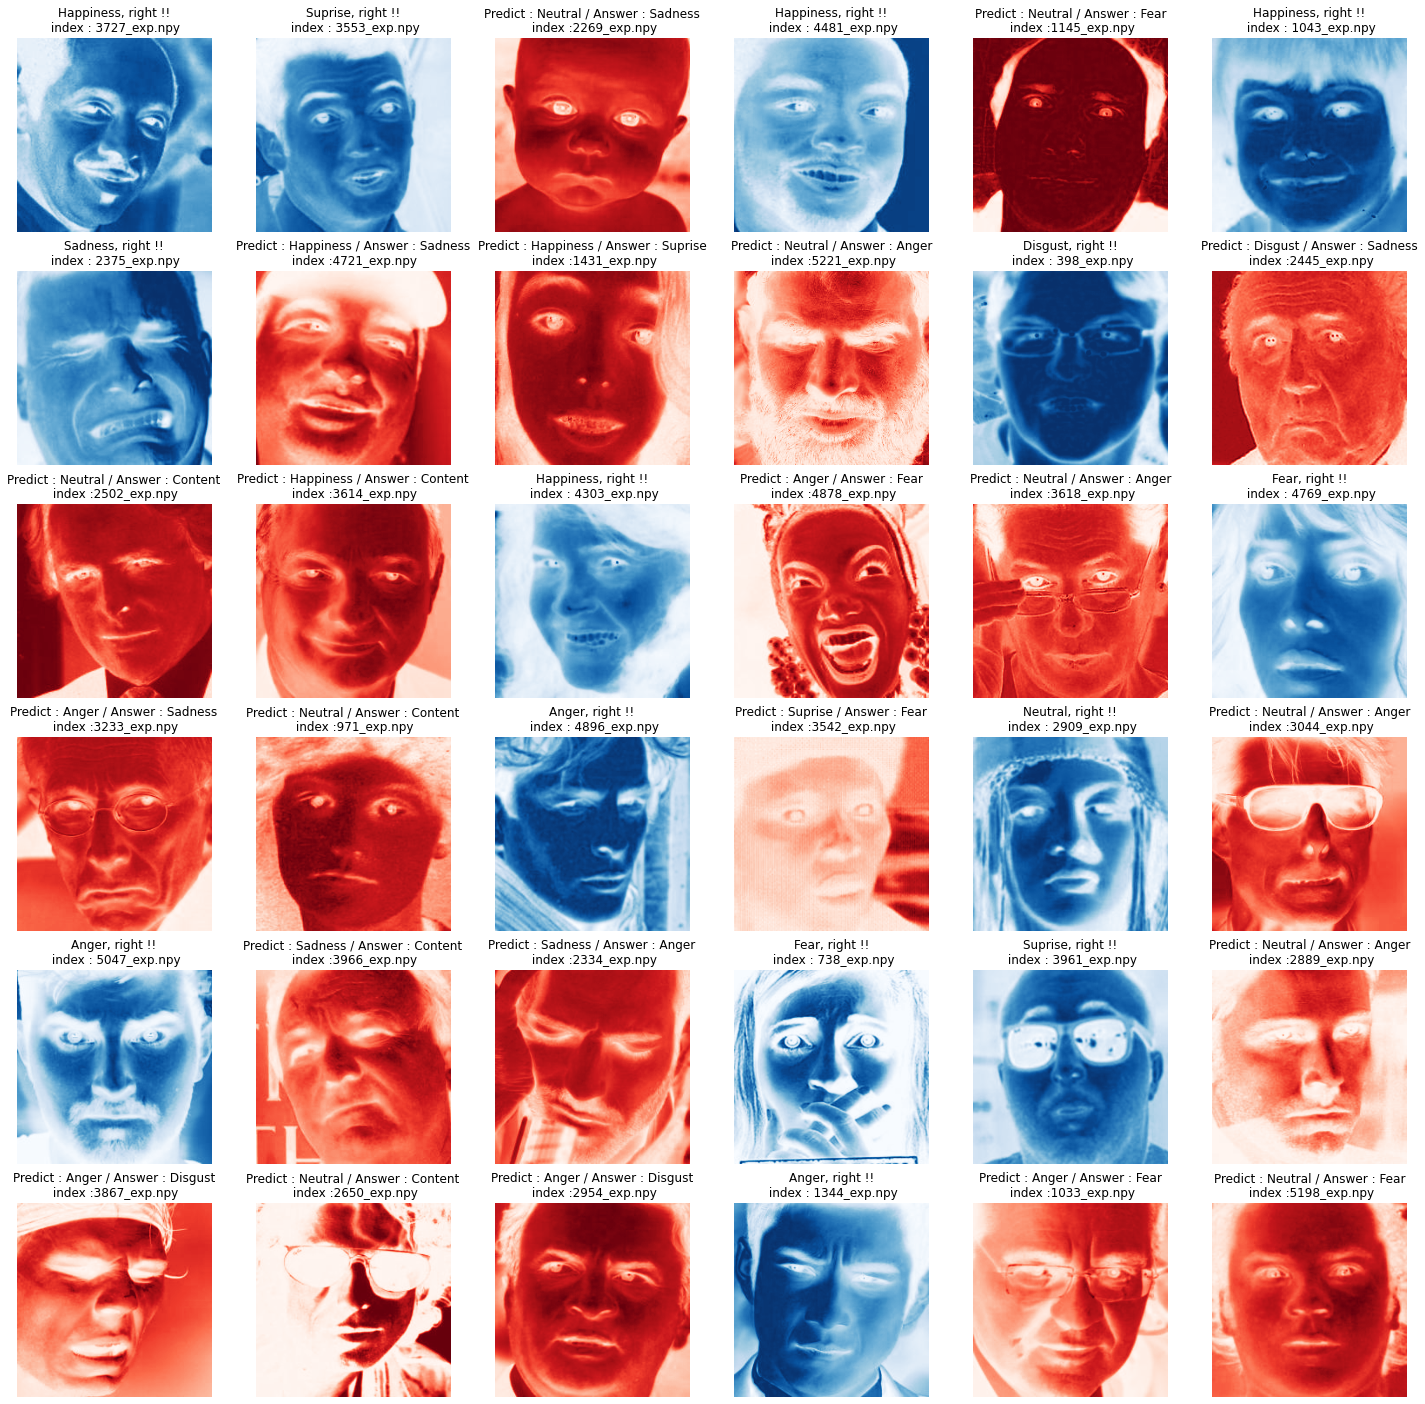

In [21]:
import cv2

columns = 6
rows = 6
fig = plt.figure(figsize=(25,25))

device = "cuda"

# inference
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(4000)
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
    

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    #test_dataset = test_dataset.numpy()
    label = label_tags[test_dataset[data_idx][1].item()]
    
    
    x = label_load("/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/")[data_idx].split('/')
    x = x[-1]
    
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!\n index : ' + str(x))
        cmap = 'Blues'
    else:
        plt.title('Predict : ' + pred + ' / Answer : ' +  label + '\n index :' + str(x))
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    #plt.imshow(plot_img)
    plt.axis('off')
    
plt.show() 

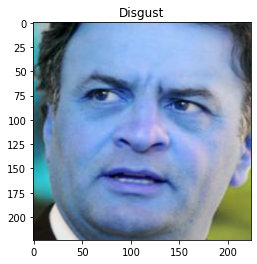

In [22]:
num = 2954
x = cv2.imread(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/images/{num}.jpg", cv2.IMREAD_COLOR)
y = int(np.load(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/{num}_exp.npy"))

label_tags = {
    0 : 'Neutral', # 중립
    1 : 'Happiness', # 기쁨
    2 : 'Sadness', # 슬픔
    3 : 'Suprise', # 놀람
    4 : 'Fear', # 두려움
    5 : 'Disgust', # 역겨움
    6 : 'Anger', # 분노
    7 : 'Content' # 만족
}

plt.title(label_tags[y])
plt.imshow(x)



In [ ]:
!tensorboard --logdir=runs

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 